In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#TO CREATE VALIDATION SET and TEST SET!! DONE :)
import os, random
import shutil

src_dir1 = "/content/drive/My Drive/final_year_project/IMAC/training/happy/"
src_dir2 = "/content/drive/My Drive/final_year_project/IMAC/training/sad/"

dst_dir1 = "/content/drive/My Drive/final_year_project/IMAC/validation/happy/"
dst_dir2 = "/content/drive/My Drive/final_year_project/IMAC/validation/sad/"
dst_dir3 = "/content/drive/My Drive/final_year_project/IMAC/testing/happy/"
dst_dir4 = "/content/drive/My Drive/final_year_project/IMAC/testing/sad/"

file_list1 = os.listdir(src_dir1)
file_list2 = os.listdir(src_dir2)

#Moving happy to validation folder
for i in range(545):
  try:
    a = random.choice(file_list1)
    file_list1.remove(a)
    shutil.move(src_dir1 + a, dst_dir1)
  except:
    continue

#Moving happy images to test
for i in range(545):
  try:
    a = random.choice(file_list1)
    file_list1.remove(a)
    shutil.move(src_dir1 + a, dst_dir3)
  except:
    continue


for i in range(527):
  try:
    a = random.choice(file_list2)
    file_list2.remove(a)
    shutil.move(src_dir2 + a, dst_dir2)
  except:
    continue

for i in range(527):
  try:
    b = random.choice(file_list2)
    file_list2.remove(b)
    shutil.move(src_dir2 + b, dst_dir4)
  except:
    continue

In [ ]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" \
    -O "/content/drive/My Drive/final_year_project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

--2020-01-26 08:16:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/drive/My Drive/final_year_project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/drive/My D 100%[===================>]  83.84M  6.50MB/s    in 13s     

2020-01-26 08:16:59 (6.50 MB/s) - ‘/content/drive/My Drive/final_year_project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#Training using transfer learning-Inception and one dense layer of Neural network
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/drive/My Drive/final_year_project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 
from tensorflow.keras import optimizers
adm=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adm,metrics=['acc'])



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_127 (BatchN (None, 74, 74, 32)   96          conv2d_146[0][0]                 
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 74, 74, 32)   0           batch_normalization_127[0][0]    
_______________________________________________________________________________________

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) 
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/final_year_project/IMAC/training/',
    target_size=(150,150), 
    batch_size=50, 
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/final_year_project/IMAC/validation/',
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=10,
        class_mode='binary')

filepath="/content/drive/My Drive/final_year_project/checkpoints_for_imac.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#model.load_weights(checkpoint_path)


#ADAM optimiser
#loss,acc=model.evaluate(train_generator, verbose=2)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=50,
    verbose=1,
    shuffle=True,
    validation_data = validation_generator,
    callbacks=[checkpoint]
)

print(history.history['acc'][-1])

Found 3213 images belonging to 2 classes.
Found 1072 images belonging to 2 classes.
Epoch 1/50
10/10 [==============================] - 400s 40s/step - loss: 1.6355 - acc: 0.6020 - val_loss: 2.1911 - val_acc: 0.6194
Epoch 2/50
10/10 [==============================] - 9s 920ms/step - loss: 0.6375 - acc: 0.7460 - val_loss: 1.8375 - val_acc: 0.6362
Epoch 3/50
10/10 [==============================] - 9s 900ms/step - loss: 0.5357 - acc: 0.7740 - val_loss: 0.4585 - val_acc: 0.8377
Epoch 4/50
10/10 [==============================] - 9s 914ms/step - loss: 0.4490 - acc: 0.7711 - val_loss: 0.5430 - val_acc: 0.7957
Epoch 5/50
10/10 [==============================] - 9s 900ms/step - loss: 0.4187 - acc: 0.8340 - val_loss: 0.9208 - val_acc: 0.7024
Epoch 6/50
10/10 [==============================] - 8s 799ms/step - loss: 0.4098 - acc: 0.8300 - val_loss: 0.8087 - val_acc: 0.7603
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 0.2988 - acc: 0.8760 - val_loss: 0.5230 - val_acc: 0

Text(0.5, 1.0, 'Accuracy Curves')

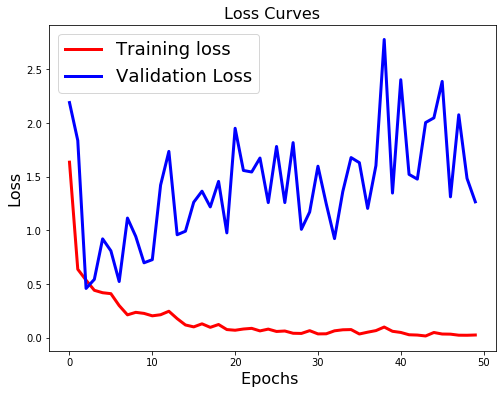

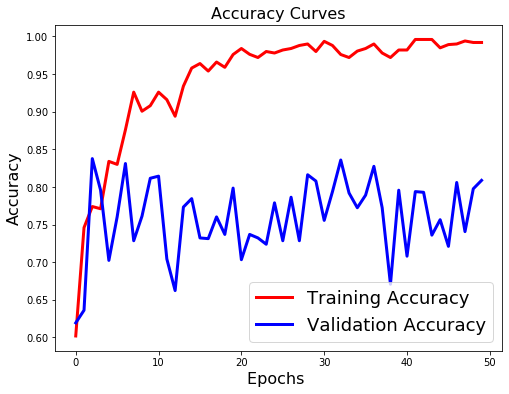

In [ ]:
#Plot the Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save("/content/drive/My Drive/final_year_project/IMAC_saved_model_using_inception")

In [ ]:
import tensorflow as tf
import os
DESIRED_ACCURACY = 0.999

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
      if(logs.get('acc')>=DESIRED_ACCURACY):
          print("Reached 99.9% accuracy so cancelling training!")
          self.model.stop_training=True

callbacks = myCallback()
    
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(), 
tf.keras.layers.Dense(128,activation=tf.nn.relu),
tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras import optimizers
adm=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adm,metrics=['acc'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) 
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/final_year_project/IMAC/training/', 
    target_size=(150,150), 
    batch_size=80, 
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/final_year_project/IMAC/validation/', 
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary'
)

filepath="/content/drive/My Drive/final_year_project/weights.IMAC.CNN.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=50,
    verbose=1,
    shuffle=True,
    validation_data = validation_generator,
    validation_steps=8
    #callbacks=[callbacks, checkpoint]
)

print(history.history['acc'][-1])

Found 3213 images belonging to 2 classes.
Found 1072 images belonging to 2 classes.
Epoch 1/50
8/8 [==============================] - 432s 54s/step - loss: 0.8223 - acc: 0.5000 - val_loss: 0.6838 - val_acc: 0.5000
Epoch 2/50
8/8 [==============================] - 188s 23s/step - loss: 0.6795 - acc: 0.5125 - val_loss: 0.6654 - val_acc: 0.5000
Epoch 3/50
8/8 [==============================] - 327s 41s/step - loss: 0.6795 - acc: 0.5156 - val_loss: 0.6447 - val_acc: 0.6833
Epoch 4/50
8/8 [==============================] - 288s 36s/step - loss: 0.6633 - acc: 0.6143 - val_loss: 0.6355 - val_acc: 0.5583
Epoch 5/50
8/8 [==============================] - 311s 39s/step - loss: 0.6309 - acc: 0.6625 - val_loss: 0.6117 - val_acc: 0.6958
Epoch 6/50
8/8 [==============================] - 40s 5s/step - loss: 0.6409 - acc: 0.6719 - val_loss: 0.5520 - val_acc: 0.7667
Epoch 7/50
8/8 [==============================] - 5s 610ms/step - loss: 0.6185 - acc: 0.6734 - val_loss: 0.5503 - val_acc: 0.7750
Epoch 8/

Text(0.5, 1.0, 'Accuracy Curves')

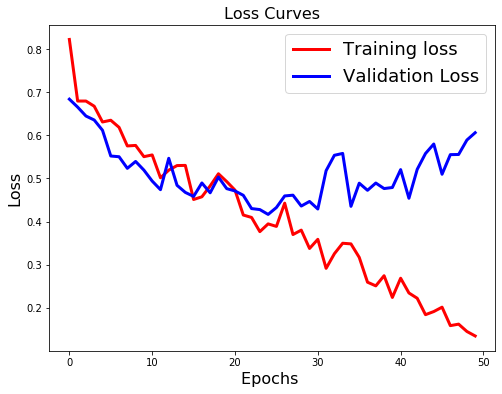

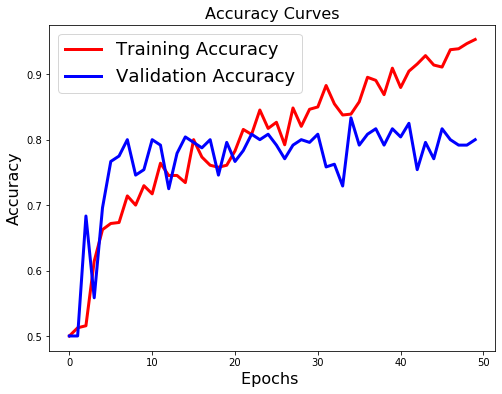

In [ ]:
#Plot the Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save("/content/drive/My Drive/final_year_project/imac_saved_model_using_cnn")

In [ ]:
#Training using transfer learning-Inception and one dense layer of Neural network
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/drive/My Drive/final_year_project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension

x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(last_output),
x=tf.keras.layers.MaxPooling2D(2,2)(x),
#tf.keras.layers.Flatten(), #Features is in the form of matrix is flattened into a 1D array
#tf.keras.layers.Dense(128,activation=tf.nn.relu),
#tf.keras.layers.Dense(1, activation='sigmoid')
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 
from tensorflow.keras import optimizers
adm=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adm,metrics=['acc'])


In [ ]:
import tensorflow as tf


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/final_year_project/IMAC_saved_model_using_inception')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/My Drive/final_year_project/imac_saved_model_using_cnn')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/final_year_project/IMAC/testing',
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary', 
        shuffle=False)  # to keep data in same order as labels


Found 1072 images belonging to 2 classes.


In [ ]:
vals= new_model.evaluate(test_generator, verbose=1) #inception model

In [ ]:
vals2= cnn_model.evaluate(test_generator, verbose=1) #cnn model

1072/1072 [==============================] - 9s 8ms/step - loss: 0.5101 - acc: 0.7743


In [ ]:
pred = new_model.predict_generator(test_generator, verbose=1)

1072/1072 [==============================] - 14s 13ms/step


In [ ]:
pred2 = cnn_model.predict_generator(test_generator, verbose=1)

1072/1072 [==============================] - 8s 8ms/step


In [ ]:
 for i in range(1072): 
  if pred[i]>0.5:
    print(i)
    y_pred[i]=1
    print(" is sad")
  else:
    print(i)
    y_pred[i]=0
    print(" is happy")

In [ ]:
from sklearn.metrics import confusion_matrix       #For inception
cm=confusion_matrix(test_generator.classes,y_pred)
print(cm)

[[511  34]
 [151 376]]


In [ ]:
print('Test loss, Test accuracy:', vals)

Test loss, Test accuracy: [1.1069465661184437, 0.82742536]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_generator.classes,y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.77190332 0.91707317]
recall: [0.93761468 0.71347249]
fscore: [0.84672742 0.80256137]
support: [545 527]


In [ ]:

spec=[0,0]
spec[0]=cm[1,1]/(cm[0,1]+cm[1,1])
spec[1]=cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: {}'.format(spec))


Specificity: [0.9170731707317074, 0.7719033232628398]


In [ ]:
from sklearn.metrics import classification_report as report

In [ ]:
rep=report(test_generator.classes,y_pred)
print(rep)

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       545
           1       0.92      0.71      0.80       527

    accuracy                           0.83      1072
   macro avg       0.84      0.83      0.82      1072
weighted avg       0.84      0.83      0.83      1072



In [ ]:
for i in range(1072): 
  if pred2[i]>0.5:
    print(i)
    y_pred[i]=1
    print(" is sad")
  else:
    print(i)
    y_pred[i]=0
    print(" is happy")

In [ ]:
from sklearn.metrics import confusion_matrix       #For CNN - 3layers
confusion_matrix(test_generator.classes,y_pred)

array([[399, 146],
       [ 96, 431]])

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = new_model.predict(images, batch_size=10)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is sad")
  else:
    print(fn + " is happy")